# RQ5: What is the evolution rate of Dockerfiles?

## Load data and import libraries

In [1]:
%load_ext autoreload

# Auto reloading causes the kernel to reload the libraries we have
%autoreload 2

# usual imports for visualization, etc.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdate
import matplotlib.ticker as ticker
import datetime
import re

# make it reproducible
np.random.seed(0)

# show plots inline
%matplotlib inline

In [2]:
data_folder = '../data/'

docker_image_dataset = pd.read_csv(data_folder + 'docker_image_dataset.csv', error_bad_lines=False, warn_bad_lines=False,low_memory=False)
dockerfiles = docker_image_dataset[docker_image_dataset['collection_method'].notnull()].copy()
dockerfiles.index=range(0,dockerfiles.shape[0])

## Define helper functions and defaults

In [3]:
# Helper Functions
!mkdir figs
figs_dir = 'figs/'

In [4]:
from cycler import cycler
def set_plt_rc():
    SMALL_SIZE = 8
    MEDIUM_SIZE = 10
    BIGGER_SIZE = 12
    
    font = {'family': 'serif','size': BIGGER_SIZE}
    plt.rc('font', **font)

    plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
        
    plt.rc('axes', prop_cycle=(cycler(color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
                                         '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
                                         '#bcbd22', '#17becf']) +
                           cycler(linestyle=['-', '--', ':', '-.','-', '--', ':', '-.','-', '--'])))
    
set_plt_rc()

## The evolution rate of Dockerfile versus the evolution rate of the source code

In [5]:
# Function for converting stringified list into list
def strlist2list(s):
    try:
        return(eval(s))
    except:
        return np.nan

def commit_count(l):
    if(type(l)!=list):
        return np.nan
    else:
        length=len(l)
        if(length==0):
            return np.nan
        else:
            return length
    

dockerfiles['dockerfile_commit_count']=np.nan
dockerfiles['dockerfile_commit_count']=dockerfiles['dockerfile_commit_sha'].apply(lambda x: commit_count(strlist2list(x)))

In [6]:
print('Average Dockerfile commit count: ', dockerfiles['dockerfile_commit_count'].mean())
print('Average commit count: ', dockerfiles['repo_commits_count'].mean())
print('The ratio between the average commit count and average Dockerfile commit count: ', dockerfiles['repo_commits_count'].mean()/dockerfiles['dockerfile_commit_count'].mean())

Average Dockerfile commit count:  5.879278935892334
Average commit count:  10.690817899072544
The ratio between the average commit count and average Dockerfile commit count:  1.818389298355332


In [7]:
max_num_rows=dockerfiles.shape[0]
ratio_between_dockerfile_and_all_commits=pd.Series([np.nan]*dockerfiles.shape[0])
for i in range(max_num_rows):
    row = dockerfiles.iloc[i, :]
    ratio_between_dockerfile_and_all_commits[i]=row['repo_commits_count']/row['dockerfile_commit_count']
dockerfiles['ratio_between_dockerfile_and_all_commits']=ratio_between_dockerfile_and_all_commits

In [8]:
#Over time
update_year=pd.DatetimeIndex(dockerfiles['updated_at']).year
update_month=pd.DatetimeIndex(dockerfiles['updated_at']).month
dockerfiles['update_year']=update_year
dockerfiles['update_month']=update_month
year_list=range(2014,2020)
month_list=range(1,13)
time=pd.Series()
commit_ratio=pd.Series()
for year in year_list:
    for month in month_list:
        if(year==2019 and month==4):
            break
        time=time.append(pd.Series(str(year)+'-'+str(month),index=[0]))
        dockerfile=dockerfiles[dockerfiles['update_year']==year]
        dockerfile=dockerfile[dockerfile['update_month']==month]
        ratio=dockerfile['ratio_between_dockerfile_and_all_commits']
        commit_ratio=commit_ratio.append(pd.Series(ratio.mean(),index=[0]))
time.index=range(0,len(time))
commit_ratio.index=range(0,len(commit_ratio))
ratio_over_time=pd.concat([time,commit_ratio],axis=1,keys=['time','ratio'])

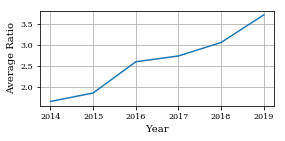

In [9]:
ratio_over_time['time']=ratio_over_time['time'].apply(lambda x:pd.Timestamp(x).year)
year=pd.Series(range(2014,2020))
ratio=pd.Series([0]*len(year))
ratio_yearly=pd.concat([year,ratio],axis=1,keys=['Year','Ratio'])
for y in range(2014,2020):
    ratio_yearly.loc[y-2014,'Ratio']=ratio_over_time[ratio_over_time['time']==y]['ratio'].mean()
fig=plt.figure(figsize=(4,2))
ax=plt.subplot(111)
ax.set_ylabel("Average Ratio")
ax.set_xlabel('Year')
ax.grid()
plt.plot(ratio_yearly['Year'],ratio_yearly['Ratio'])
fig.tight_layout()
fig.savefig(figs_dir+'commits-count-ratio-yearly', dpi=300)
fig.savefig(figs_dir+'commits-count-ratio-yearly.pdf')

In [10]:
print('The average ratio between the commit count and Dockerfile commit count:',ratio_between_dockerfile_and_all_commits.mean())

The average ratio between the commit count and Dockerfile commit count: 3.363241954839611
